In [1048]:
import pandas as pd
import pandas as pd    
import numpy as np
import matplotlib
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
,SelectKBest
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, SMOTENC
import shap
import xgboost
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
import pickle

In [769]:
# read in datasets
df1 = pd.read_csv('../data/application_record.csv')
df2 = pd.read_csv('../data/credit_record.csv')

# brief view of these two datasets

In [770]:
# check the dataset
df1.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [771]:
df1.shape

(438557, 18)

In [772]:
df2.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [773]:
df2.shape

(1048575, 3)

In [774]:
# select the first month of each id as a df3
df3 = pd.DataFrame(df2.groupby(["ID"])["MONTHS_BALANCE"].agg(min))

In [775]:
# provide month balance information in df3 to df1
new_df1 = df1.merge(df3,how='left',on='ID')

In [776]:
new_df1.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0


In [777]:
# identify client overdue for 60 days as risk customer
def risk(status):
    if status in ['2','3','4','5']:
        return 1
    else:
        return 0
df2['INDEX'] = df2['STATUS'].apply(risk)

In [778]:
# sum up the risk of each client to identify them as risk client
# identify 1 if they are high-risk and 0 if little risk
def risky(risksum):
    if risksum == 0:
        return 'risk-free'
    else:
        return 'risk'
risk = df2.groupby('ID').sum()
risk['TARGET'] = risk['INDEX'].apply(risky)

In [779]:
# merge new df1 with risk
df = new_df1.merge(risk['TARGET'],how='inner',on='ID')

In [780]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,TARGET
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-15.0,risk-free
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-14.0,risk-free
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,risk-free
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,risk-free
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,risk-free


In [781]:
df.shape

(36457, 20)

In [782]:
df.dtypes

ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
MONTHS_BALANCE         float64
TARGET                  object
dtype: object

# Exploratory Data Analysis

In [783]:
# classify columns into continuous and categorical variables
# ignore ID because it is just for identification
conti = ['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'CNT_CHILDREN', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']
cato = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
        'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 
        'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 
        'OCCUPATION_TYPE', 'MONTHS_BALANCE', 
       'TARGET']

## figures of each columns

CODE_GENDER  data describtion:
F    24430
M    12027
Name: CODE_GENDER, dtype: int64


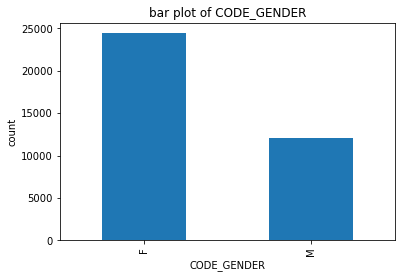

FLAG_OWN_CAR  data describtion:
N    22614
Y    13843
Name: FLAG_OWN_CAR, dtype: int64


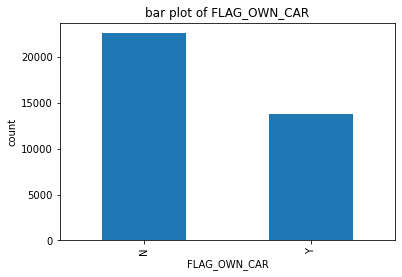

FLAG_OWN_REALTY  data describtion:
Y    24506
N    11951
Name: FLAG_OWN_REALTY, dtype: int64


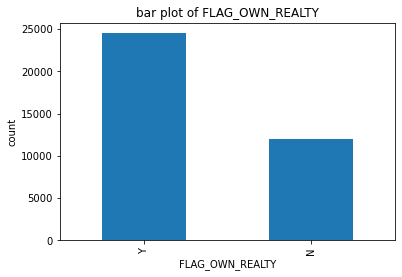

CNT_CHILDREN  data describtion:
count    36457.000000
mean         0.430315
std          0.742367
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: CNT_CHILDREN, dtype: float64


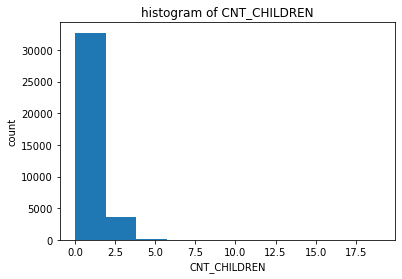

AMT_INCOME_TOTAL  data describtion:
count    3.645700e+04
mean     1.866857e+05
std      1.017892e+05
min      2.700000e+04
25%      1.215000e+05
50%      1.575000e+05
75%      2.250000e+05
max      1.575000e+06
Name: AMT_INCOME_TOTAL, dtype: float64


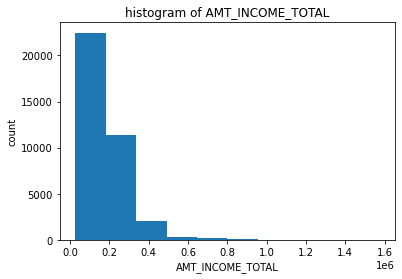

NAME_INCOME_TYPE  data describtion:
Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: NAME_INCOME_TYPE, dtype: int64


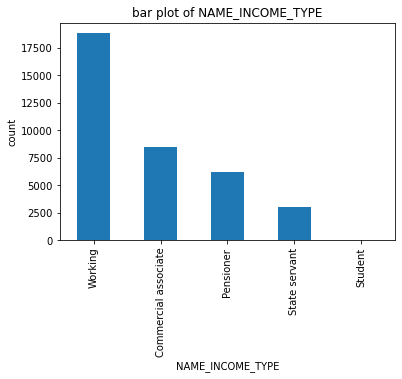

NAME_EDUCATION_TYPE  data describtion:
Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: NAME_EDUCATION_TYPE, dtype: int64


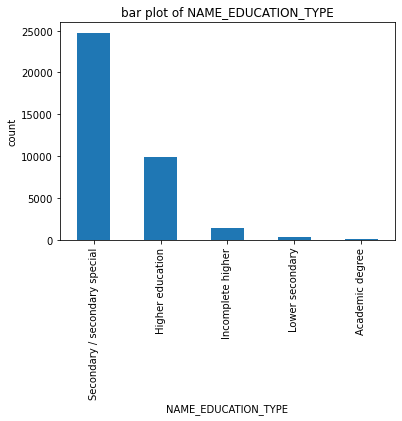

NAME_FAMILY_STATUS  data describtion:
Married                 25048
Single / not married     4829
Civil marriage           2945
Separated                2103
Widow                    1532
Name: NAME_FAMILY_STATUS, dtype: int64


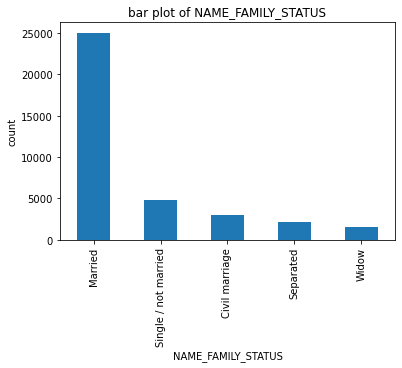

NAME_HOUSING_TYPE  data describtion:
House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: NAME_HOUSING_TYPE, dtype: int64


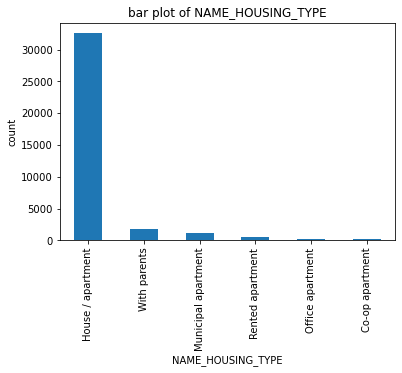

DAYS_BIRTH  data describtion:
count    36457.000000
mean    -15975.173382
std       4200.549944
min     -25152.000000
25%     -19438.000000
50%     -15563.000000
75%     -12462.000000
max      -7489.000000
Name: DAYS_BIRTH, dtype: float64


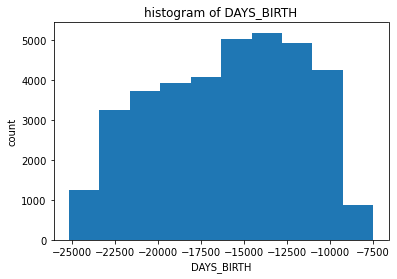

DAYS_EMPLOYED  data describtion:
count     36457.000000
mean      59262.935568
std      137651.334859
min      -15713.000000
25%       -3153.000000
50%       -1552.000000
75%        -408.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


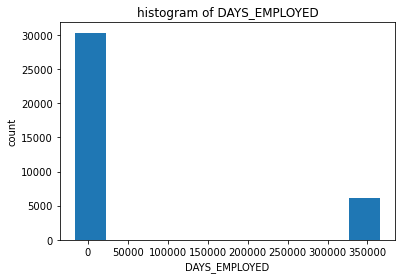

FLAG_MOBIL  data describtion:
1    36457
Name: FLAG_MOBIL, dtype: int64


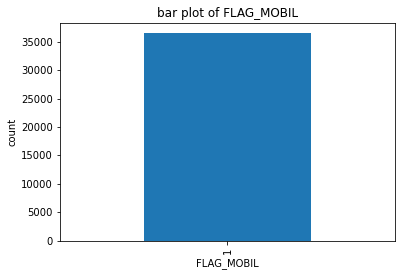

FLAG_WORK_PHONE  data describtion:
0    28235
1     8222
Name: FLAG_WORK_PHONE, dtype: int64


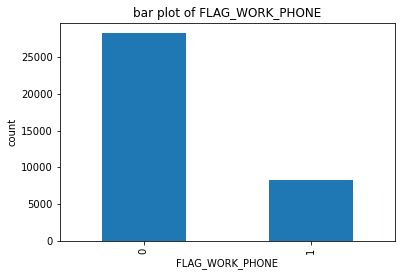

FLAG_PHONE  data describtion:
0    25709
1    10748
Name: FLAG_PHONE, dtype: int64


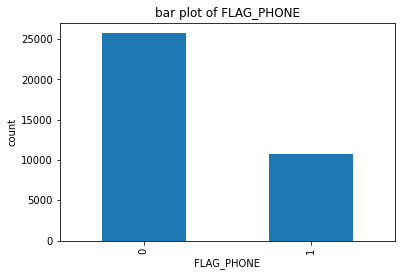

FLAG_EMAIL  data describtion:
0    33186
1     3271
Name: FLAG_EMAIL, dtype: int64


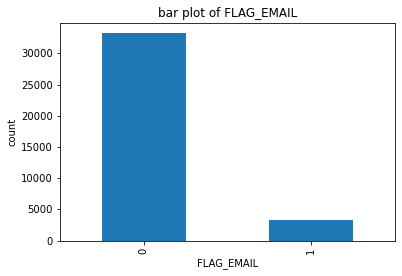

OCCUPATION_TYPE  data describtion:
Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64


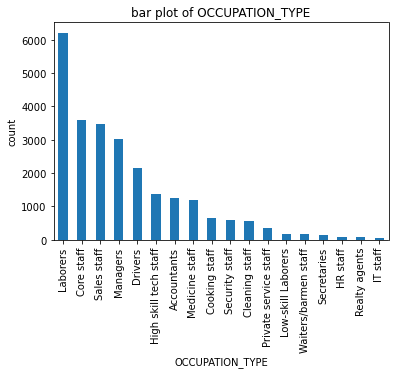

CNT_FAM_MEMBERS  data describtion:
count    36457.000000
mean         2.198453
std          0.911686
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: CNT_FAM_MEMBERS, dtype: float64


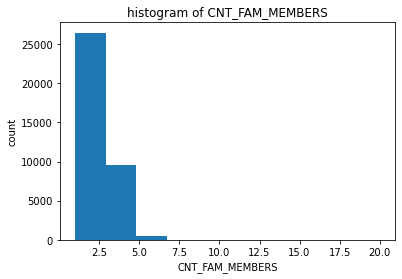

MONTHS_BALANCE  data describtion:
-7.0     889
-11.0    828
-6.0     824
-8.0     820
-5.0     816
        ... 
-58.0    333
-60.0    321
 0.0     315
-59.0    307
-57.0    304
Name: MONTHS_BALANCE, Length: 61, dtype: int64


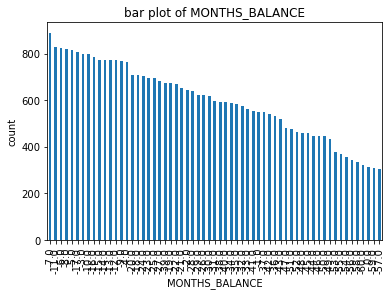

TARGET  data describtion:
risk-free    35841
risk           616
Name: TARGET, dtype: int64


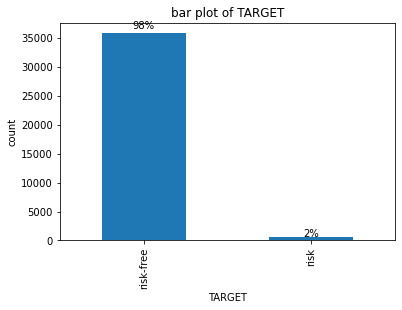

In [621]:
for column in df.columns:
    if column in conti:
        print(column, " data describtion:")
        print(df[column].describe())
        df[column].plot.hist(bins=10)
        plt.title('histogram of ' + column)
        plt.xlabel(column)
        plt.ylabel('count')
        plt.savefig('../figures/' + column + '.png')
        plt.show()
    if column in cato:
        print(column, " data describtion:")
        print(df[column].value_counts())
        ax = pd.value_counts(df[column]).plot.bar()
        plt.title('bar plot of ' + column)
        plt.ylabel('count')
        plt.xlabel(column)
        # show the TARGET is imbalanced
        if column == 'TARGET':
            for p in ax.patches:
                width = p.get_width()
                height = p.get_height()
                x, y = p.get_xy() 
                whole = df['TARGET'].count()
                ax.annotate(f'{height/whole:.0%}', (x + width/2, y + height*1.02), ha='center')
        plt.savefig('../figures/' + column + '.png')
        plt.show()

## figures of two columns

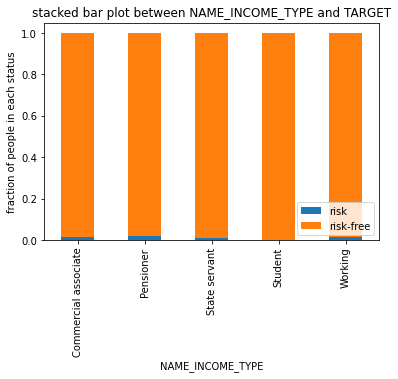

In [622]:
# stacked bar plot between NAME_INCOME_TYPE and TARGET
count_matrix = df.groupby(['NAME_INCOME_TYPE', 'TARGET']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.title('stacked bar plot between NAME_INCOME_TYPE and TARGET')
plt.ylabel('fraction of people in each status')
plt.legend(loc=4)
plt.savefig('../figures/NAME_INCOME_TYPE and TARGET.pdf')
plt.show()

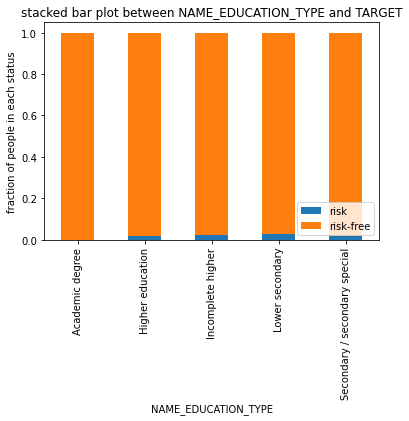

In [623]:
# stacked bar plot between NAME_EDUCATION_TYPE and TARGET
count_matrix = df.groupby(['NAME_EDUCATION_TYPE', 'TARGET']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True)
plt.title('stacked bar plot between NAME_EDUCATION_TYPE and TARGET')
plt.ylabel('fraction of people in each status')
plt.legend(loc=4)
plt.savefig('../figures/NAME_EDUCATION_TYPE and TARGET.png')
plt.show()

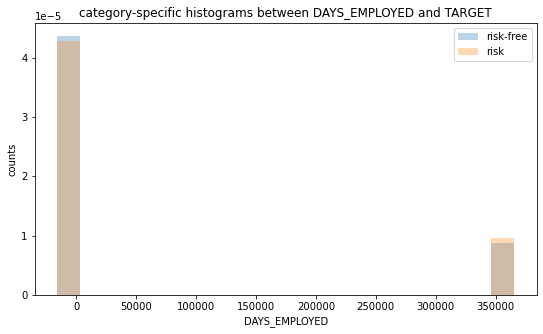

In [624]:
# category-specific histograms between DAYS_EMPLOYED and TARGET
plt.figure(figsize = (9,5))
categories = df['TARGET'].unique()
bin_range = (df['DAYS_EMPLOYED'].min(),df['DAYS_EMPLOYED'].max())
for c in categories:
    plt.hist(df[df['TARGET']==c]['DAYS_EMPLOYED'],alpha=0.3,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.title('category-specific histograms between DAYS_EMPLOYED and TARGET')
plt.ylabel('counts')
plt.xlabel('DAYS_EMPLOYED')
plt.savefig('../figures/DAYS_EMPLOYED and TARGET.png')
plt.show()


<Figure size 720x720 with 0 Axes>

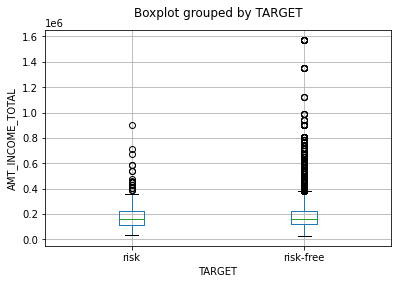

In [21]:
# box plot between AMT_INCOME_TOTAL and TARGET
plt.figure(figsize=(10,10))
df[['AMT_INCOME_TOTAL','TARGET']].boxplot(by='TARGET')
plt.title('')
plt.ylabel('AMT_INCOME_TOTAL')
plt.xlabel('TARGET')
plt.savefig('../figures/AMT_INCOME_TOTAL and TARGET.png')
plt.show()

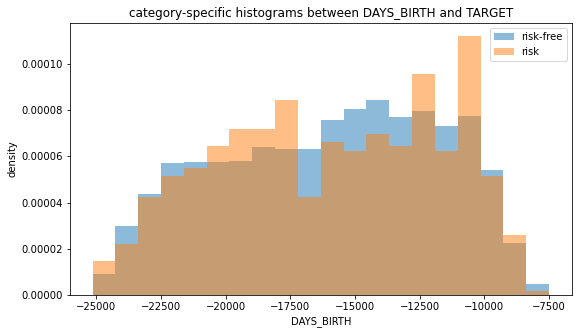

In [22]:
# category-specific histograms between DAYS_BIRTH and TARGET
plt.figure(figsize = (9,5))
categories = df['TARGET'].unique()
bin_range = (df['DAYS_BIRTH'].min(),df['DAYS_BIRTH'].max())
for c in categories:
    plt.hist(df[df['TARGET']==c]['DAYS_BIRTH'],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.title('category-specific histograms between DAYS_BIRTH and TARGET')
plt.ylabel('density')
plt.xlabel('DAYS_BIRTH')
plt.savefig('../figures/DAYS_BIRTH and TARGET.png')
plt.show()

## scatter matrix

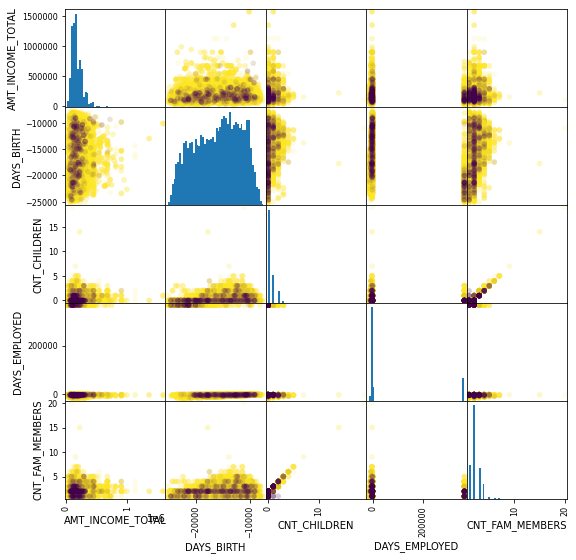

In [23]:
pd.plotting.scatter_matrix(df[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'CNT_CHILDREN', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']],figsize=(9, 9), marker='o',hist_kwds={'bins': 50}, 
                           s=30, alpha=.1, c = pd.get_dummies(df['TARGET']).iloc[:,1]) 

plt.savefig('../figures/scatter_matrix.png', dpi = 300)

# Data preprocessing

## handle missing values

In [784]:
# check missing values
df.isnull().sum(axis=0)/df.shape[0]

ID                     0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
AMT_INCOME_TOTAL       0.000000
NAME_INCOME_TYPE       0.000000
NAME_EDUCATION_TYPE    0.000000
NAME_FAMILY_STATUS     0.000000
NAME_HOUSING_TYPE      0.000000
DAYS_BIRTH             0.000000
DAYS_EMPLOYED          0.000000
FLAG_MOBIL             0.000000
FLAG_WORK_PHONE        0.000000
FLAG_PHONE             0.000000
FLAG_EMAIL             0.000000
OCCUPATION_TYPE        0.310585
CNT_FAM_MEMBERS        0.000000
MONTHS_BALANCE         0.000000
TARGET                 0.000000
dtype: float64

The only missing value is OCCUPATION_TYPE, which is a categorical variable. About 30% of it is missing, so they cannot be dropped directly. Treat them as another category

In [785]:
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna(value="missing")

## preprocessing data

In [786]:
df['TARGET'] = df['TARGET'].replace(['risk-free','risk'],[0,1])

In [787]:
ordinal_ftrs = ['FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_EDUCATION_TYPE'] 
ordinal_cats = [['N','Y'],['N','Y'],['Lower secondary','Secondary / secondary special',
                                    'Incomplete higher','Higher education','Academic degree']]
onehot_ftrs = ['CODE_GENDER','NAME_INCOME_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']
std_ftrs = ['CNT_CHILDREN','AMT_INCOME_TOTAL','DAYS_BIRTH','DAYS_EMPLOYED','CNT_FAM_MEMBERS','MONTHS_BALANCE']

# build preprocessor

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
standard_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std', standard_transformer, std_ftrs),
        ('cat', categorical_transformer, onehot_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 

## train test split

In [788]:
X = df.drop(['TARGET','ID'],axis=1)
y = df['TARGET']

In [789]:
y.value_counts()

0    35841
1      616
Name: TARGET, dtype: int64

In [790]:
sm = SMOTENC(categorical_features=[0,1,2,5,6,7,8,15])
y = y.astype('int')
X_balance,y_balance = sm.fit_resample(X,y)
X_balance = pd.DataFrame(X_balance, columns = X.columns)

In [791]:
y_balance.value_counts()

1    35841
0    35841
Name: TARGET, dtype: int64

In [804]:
X_balance.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,missing,2.0,-15.0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,missing,2.0,-14.0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0


In [1094]:
def MLpipe_KFold_F1(X,y,preprocessor,ML_algo,param_grid):    
    # has_rs tells whether the input algorithm takes random_state as an argument
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.
    '''
    
    test_scores = []
    best_models = []

    # loop through 10 random states
    for i in range(10):
        random_state = 42 * i
    
        # split data to other/test 80/20, and the use KFold with 4 folds
        # stratified train-test split
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,stratify=y,random_state=random_state)
        kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=random_state)
        
        # loop through the hyperparameter combinations or use GridSearchCV
        # for each combination, calculate the train and validation scores using the evaluation metric
        pipe = make_pipeline(preprocessor,ML_algo)
        paramGrid = {str(ML_algo)[0:-2].lower()+'__'+item[0]: item[1] for item in param_grid.items()}
        
        # check if random state should be set
        if 'random_state' in ML_algo.get_params():
            paramGrid[str(ML_algo)[0:-2].lower()+'__random_state'] = [random_state]
        
        grid = GridSearchCV(pipe, param_grid=paramGrid,scoring = 'f1',
                cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
        #print(grid.estimator.get_params().keys())
  
        # find which hyperparameter combination gives the best validation score
        grid.fit(X_other, y_other)
        print('best model parameters:',grid.best_params_)
        
        # calculate the test score
        y_test_pred = grid.predict(X_test)
        pred_df = pd.DataFrame(y_test_pred)
        pred_df.to_csv("../results/" + str(ML_algo)[0:-2] + str(i) + "prediction.csv")
        f1 = fbeta_score(y_test,y_test_pred,1)     # use precision as test score
        
        # append the test score and the best model to the lists
        test_scores.append(f1)
        best_models.append(grid)
        
        # save gird
        filename = "../results/" + str(ML_algo)[0:-2] + str(i) + "model.save"
        file = open(filename, "wb")
        pickle.dump((grid.best_estimator_[-1],X_test,y_test),file)
        file.close()
        
    return best_models, test_scores

In [1095]:
# logistic regression tunning regularity strength C
ML_algo = LogisticRegression()

param_grid = {'C': [1e1, 1e2, 1e3]}

lr_models, lr_scores = MLpipe_KFold_F1(X_balance,y_balance,preprocessor,ML_algo,param_grid)
print(lr_scores)

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.2s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 100.0, 'logisticregression__random_state': 0}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.2s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 10.0, 'logisticregression__random_state': 42}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.4s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 10.0, 'logisticregression__random_state': 84}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.4s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 10.0, 'logisticregression__random_state': 126}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.6s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 100.0, 'logisticregression__random_state': 168}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.1s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 10.0, 'logisticregression__random_state': 210}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.1s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 10.0, 'logisticregression__random_state': 252}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.0s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 1000.0, 'logisticregression__random_state': 294}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.0s finished
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best model parameters: {'logisticregression__C': 10.0, 'logisticregression__random_state': 336}
Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.3s finished


best model parameters: {'logisticregression__C': 1000.0, 'logisticregression__random_state': 378}
[0.6800952705001703, 0.6810006761325219, 0.6840724042796582, 0.6853742646561634, 0.6822208696828296, 0.6837262408489488, 0.6836535220761711, 0.6884558126945459, 0.6835391779712492, 0.6893784849721203]


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error


In [1096]:
# random forest
ML_algo = RandomForestClassifier()
param_grid = {
              'max_depth': [40, 60, 80], # the max_depth should be smaller or equal than the number of features roughly
              'max_features': [0.3, 0.5, 0.7], 
              'n_estimators': [50,60,70]
              } 


rf_models, rf_scores = MLpipe_KFold_F1(X_balance,y_balance,preprocessor,ML_algo,param_grid)
print(rf_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.2min finished


best model parameters: {'randomforestclassifier__max_depth': 60, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__random_state': 0}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.5min finished


best model parameters: {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 42}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.2min finished


best model parameters: {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 0.7, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__random_state': 84}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.1min finished


best model parameters: {'randomforestclassifier__max_depth': 60, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__random_state': 126}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.5min finished


best model parameters: {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 0.7, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__random_state': 168}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.1min finished


best model parameters: {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 0.7, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__random_state': 210}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.5min finished


best model parameters: {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__random_state': 252}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.3min finished


best model parameters: {'randomforestclassifier__max_depth': 40, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__random_state': 294}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.3min finished


best model parameters: {'randomforestclassifier__max_depth': 60, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__random_state': 336}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.7min finished


best model parameters: {'randomforestclassifier__max_depth': 60, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 70, 'randomforestclassifier__random_state': 378}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error


[0.987031195233088, 0.9889417693169094, 0.9880985718286194, 0.9891403348980592, 0.9883126880817412, 0.9877613819148192, 0.9885894294714735, 0.9867002659946802, 0.9874851429769977, 0.9877425229389928]


In [1097]:
# support vector machine
# ML_algo = SVC()
# param_grid = {
#               'gamma': [0.3], 
#               'C': [1e2, 1e3]
#               } 


# svc_models, svc_scores = MLpipe_KFold_F1(X_balance,y_balance,preprocessor,ML_algo,param_grid)
# print(svc_scores)

In [1098]:
# k nearest neighbor classification
ML_algo = KNeighborsClassifier()
param_grid = {'n_neighbors': [1, 3], 
             'weights': ['uniform', 'distance']}

knn_models, knn_scores = MLpipe_KFold_F1(X_balance,y_balance,preprocessor,ML_algo,param_grid)
print(knn_scores)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.2min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.2min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.8min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.6min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.3min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  2.1min finished


best model parameters: {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__weights': 'uniform'}
[0.9688993558218467, 0.970659302726959, 0.9678310092503106, 0.9698724577731818, 0.9698558322411533, 0.9668801211870826, 0.9693955094991366, 0.9683483068417416, 0.9680044131843883, 0.9688490696071674]


Pass beta=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error


In [1099]:
# xgboost
xgb_scores = []
xgb_models = []
    
for i in range(10):
    random_state = 42 * i
    
    X_other, X_test, y_other, y_test = train_test_split(X_balance, y_balance, test_size=0.2, stratify=y_balance, random_state=random_state)
    X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.2, stratify=y_other, random_state=random_state)
    
    # fit_transform the training set
    X_prep = preprocessor.fit_transform(X_train)
    # little hacky, but collect feature names
    feature_names = preprocessor.transformers_[0][-1] + \
                    list(preprocessor.named_transformers_['cat'][1].get_feature_names(onehot_ftrs)) + \
                    preprocessor.transformers_[2][-1]

    df_train = pd.DataFrame(data=X_prep,columns=feature_names)
    #print(df_train.shape)

    # transform the CV
    df_CV = preprocessor.transform(X_CV)
    df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
    #print(df_CV.shape)

    # transform the test
    df_test = preprocessor.transform(X_test)
    df_test = pd.DataFrame(data=df_test,columns = feature_names)
    #print(df_test.shape)
    
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [1000, 10000],		# number of trees used
                  "random_state": [random_state],
                  "seed": [0],
#                   "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
#                   "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
#                   "max_depth": [1,3,10,30,100],
                  "colsample_bytree": [0.9], # subsample ratio of points in one tree  
                  "subsample": [0.66]}		# subsample ratio to be trained

        
    XGB = XGBClassifier()
    XGB.set_params(**ParameterGrid(param_grid)[0])
    XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)

    y_test_pred = XGB.predict(df_test)
    pred_df = pd.DataFrame(y_test_pred)
    pred_df.to_csv("../results/XGBoost" + str(i) + "prediction.csv")
    
    prec = precision_score(y_test,y_test_pred)
    rec = recall_score(y_test,y_test_pred)
    f1 = (2 * prec * rec) / (prec + rec)
    xgb_scores.append(f1)
    xgb_models.append(XGB)
    
    # save model
    # save gird
    filename = "../results/XGBoost" + str(i) + "model.save"
    file = open(filename, "wb")
    pickle.dump((grid.best_estimator_[-1],X_test,y_test),file)
    file.close()
    
        

In [1100]:
# logistic regression
print('mean of test score is', np.mean(lr_scores))
print('standard deviation of test score is', np.std(lr_scores))

mean of test score is 0.6841516723814378
standard deviation of test score is 0.00279752885163297


In [1101]:
# random forest
print('mean of test score is', np.mean(rf_scores))
print('standard deviation of test score is', np.std(rf_scores))

mean of test score is 0.9879803302655381
standard deviation of test score is 0.0007519669825064504


In [1102]:
# k nearest neighbors
print('mean of test score is', np.mean(knn_scores))
print('standard deviation of test score is', np.std(knn_scores))

mean of test score is 0.9688595378132968
standard deviation of test score is 0.0010730927408188976


In [1103]:
# xgboost
print('mean of test score is', np.mean(xgb_scores))
print('standard deviation of test score is', np.std(xgb_scores))

mean of test score is 0.9902009966006045
standard deviation of test score is 0.0007448653775186328


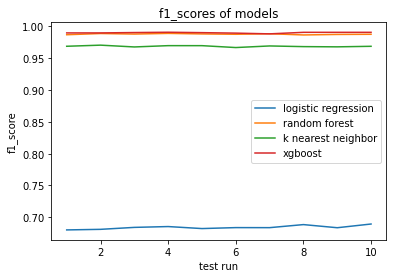

In [1104]:
# plot performance
index = np.arange(1,11)
plt.plot(index, lr_scores, label='logistic regression')
plt.plot(index, rf_scores, label='random forest')
plt.plot(index, knn_scores, label='k nearest neighbor')
plt.plot(index, xgb_scores, label='xgboost')
plt.xlabel('test run')
plt.ylabel('f1_score')
plt.title('f1_scores of models')
plt.legend()
plt.savefig('../figures/f1_scores of models.png')

## XGBoost model

In [1105]:
# best model
model = xgb_models[np.argmax(xgb_scores)]

In [1106]:
# compute how well it performs
(max(xgb_scores) - 2/3) / np.std(xgb_scores)

435.3658561074988

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


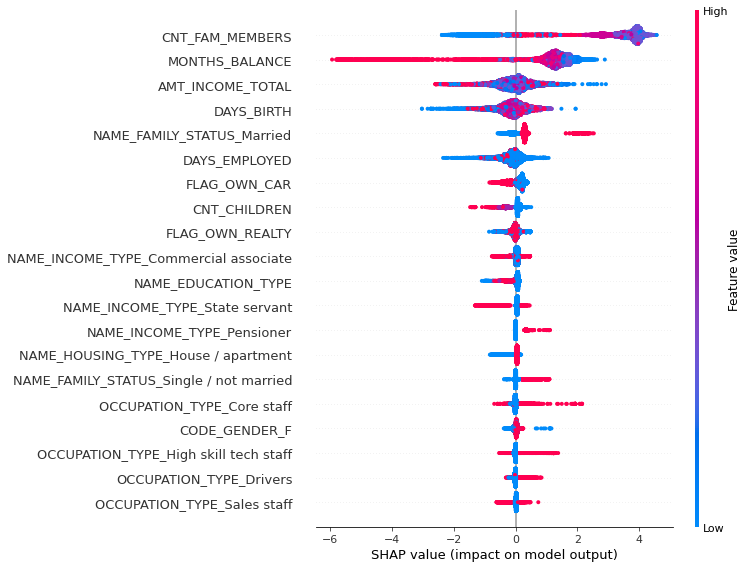

In [1019]:
# global importance
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
mybooster = model.get_booster()
model_bytearray = mybooster.save_raw()[4:]

def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun
# Shap explainer initilization
explainer = shap.TreeExplainer(mybooster)# explainer depends on the model
shap_values = explainer.shap_values(df_test)
shap.summary_plot(shap_values, df_test,show=False)
plt.savefig('../figures/global importance.png')

In [1037]:
# local importance
# index 0
index = 0 # the index of the point to explain
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)

In [1026]:
# index 100
index = 100 # the index of the point to explain
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)

In [1027]:
# index 200
index = 200 # the index of the point to explain
shap.force_plot(explainer.expected_value, shap_values[index,:], features = df_test.iloc[index,:],feature_names = feature_names)